In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import scienceplots
%matplotlib inline
from seaborn import displot, histplot
plt.style.use(['seaborn-v0_8-paper'])
from tqdm import tqdm
from shapely.geometry import LineString
from scipy import stats
from conflict import ConflictLyft
import statsmodels.api as sm 

## Data process

In [2]:
# first junction
with open('./lyft_avhv_conflict_j1.pkl', 'rb') as file:
    lyft_avhv_conflict_list1 = pickle.load(file)

with open('./lyft_hvhv_conflict_j1.pkl', 'rb') as file:
    lyft_hvhv_conflict_list1 = pickle.load(file)

lyft_conflict_list1 = lyft_avhv_conflict_list1 + lyft_hvhv_conflict_list1

# second junction
with open('./lyft_avhv_conflict_j2.pkl', 'rb') as file:
    lyft_avhv_conflict_list2 = pickle.load(file)

with open('./lyft_hvhv_conflict_j2.pkl', 'rb') as file:
    lyft_hvhv_conflict_list2 = pickle.load(file)

lyft_conflict_list2 = lyft_avhv_conflict_list2 + lyft_hvhv_conflict_list2

# report sample size
len(lyft_conflict_list1), len(lyft_conflict_list2)

(859, 886)

In [3]:
# convert the type to latest conflict object
conflict_list1 = list()
for c_index, c in enumerate(lyft_conflict_list1):
    # print(c_index)
    conflict_list1.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
        junction_id=1,
    ))
assert len(conflict_list1) == len(lyft_conflict_list1)

conflict_list2 = list()
for c_index, c in enumerate(lyft_conflict_list2):
    # print(c_index)
    conflict_list2.append(ConflictLyft(
        leader_id=c.first_id,
        follower_id=c.second_id,
        leader_time_at_conflict=c.first_time_at_conflict,
        follower_time_at_conflict=c.second_time_at_conflict,
        leader_is_av=c.is_first_AV,
        follower_is_av=c.is_second_AV,
        PET=c.PET,
        conflict_type=c.category.upper(),
        leader_traj=c.first_trajectory.xy[1:-1,:],
        follower_traj=c.second_trajectory.xy[1:-1,:],
        leader_traj_timestamp=c.first_trajectory.t[1:-1],
        follower_traj_timestamp=c.second_trajectory.t[1:-1],
        leader_traj_speed=c.first_trajectory.smoothed_v,
        follower_traj_speed=c.second_trajectory.smoothed_v,
        junction_id=2,
    ))
assert len(conflict_list2) == len(lyft_conflict_list2)

conflict_list = conflict_list1 + conflict_list2

len(conflict_list1), len(conflict_list2)

(859, 886)

In [4]:
"""
Construct a dataframe with the following columns:
- Conflict type
- Vehicle order
- PET
"""
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "minTTC"
]

# generate each rows in the dataframe
conflict_rows_in_df = list()

for index, conflict in tqdm(enumerate(conflict_list)):
    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    conflict_rows_in_df.append([
        conflict_type,
        leader_type+"-"+follower_type,
        conflict.PET,
        conflict.minimum_TTC,
    ])
conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info()

1745it [00:00, 108331.02it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1745 entries, 0 to 1744
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  1745 non-null   object 
 1   Vehicle order  1745 non-null   object 
 2   PET            1745 non-null   float64
 3   minTTC         1256 non-null   float64
dtypes: float64(2), object(2)
memory usage: 68.2+ KB


In [5]:
conflict_df.dropna(inplace=True)
conflict_df.describe()

,PET,minTTC
count,1256.000000,1256.000000
mean,4.776990,14.945458
std,2.358497,51.980654
min,0.100000,0.199954
25%,2.900000,4.374050
50%,4.200000,6.260120
75%,6.600000,11.144130
max,9.900000,948.547791


In [6]:
# Post-process: remove minTTC greater than 10s
minTTC_THRESHOLD = 10
conflict_df = conflict_df[(conflict_df["minTTC"] <= minTTC_THRESHOLD) & (conflict_df["minTTC"] >= 0)]

# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902 entries, 0 to 1744
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Conflict type  902 non-null    object 
 1   Vehicle order  902 non-null    object 
 2   PET            902 non-null    float64
 3   minTTC         902 non-null    float64
dtypes: float64(2), object(2)
memory usage: 35.2+ KB


In [7]:
conflict_df.to_csv("./outputs/trb/lyft_minttc.csv", index=False)

In [8]:
conflict_df[["Conflict type", "Vehicle order"]].value_counts()

Conflict type  Vehicle order
Cross          HV-HV            312
Merge          HV-HV            261
               AV-HV            116
Cross          HV-AV             88
Merge          HV-AV             73
Cross          AV-HV             52
dtype: int64

In [9]:
# mean
conflict_df.groupby(["Conflict type", "Vehicle order"])['minTTC'].mean()

Conflict type  Vehicle order
Cross          AV-HV            3.847012
               HV-AV            4.808126
               HV-HV            4.707623
Merge          AV-HV            5.272730
               HV-AV            7.230813
               HV-HV            6.123642
Name: minTTC, dtype: float64

In [10]:
conflict_df.groupby(["Conflict type", "Vehicle order"])['minTTC'].std()

Conflict type  Vehicle order
Cross          AV-HV            1.235444
               HV-AV            1.010519
               HV-HV            1.976755
Merge          AV-HV            1.658126
               HV-AV            1.388844
               HV-HV            1.890104
Name: minTTC, dtype: float64

In [11]:
cross_df = conflict_df[conflict_df["Conflict type"] == "Cross"]
merge_df = conflict_df[conflict_df["Conflict type"] == "Merge"]

HVHV_cross = cross_df[cross_df["Vehicle order"] == "HV-HV"]
AVHV_cross = cross_df[cross_df["Vehicle order"] == "AV-HV"]
HVAV_cross = cross_df[cross_df["Vehicle order"] == "HV-AV"]

HVHV_merge = merge_df[merge_df["Vehicle order"] == "HV-HV"]
AVHV_merge = merge_df[merge_df["Vehicle order"] == "AV-HV"]
HVAV_merge = merge_df[merge_df["Vehicle order"] == "HV-AV"]

## Stats Test

### Normality Test

In [12]:
# HVHV::Cross
stats.shapiro(HVHV_cross.minTTC).pvalue # 0.0013318812707439065

# AVHV::Cross
stats.shapiro(AVHV_cross.minTTC).pvalue # 0.009552793577313423

# HVAV::Cross
# stats.shapiro(HVAV_cross.minTTC).pvalue # 1.8525666334312518e-08

# HVHV::Merge
# stats.shapiro(HVHV_merge.minTTC).pvalue # 0.01097436249256134

# # AVHV::Merge
# stats.shapiro(AVHV_merge.minTTC).pvalue # 7.534129690611735e-05

# # HVAV::Merge
# stats.shapiro(HVAV_merge.minTTC).pvalue # 0.005976205691695213

0.009552793577313423

### Mann-Whitney U Test

In [14]:
# HVHV::HVAV | Cross
stats.mannwhitneyu(HVHV_cross.minTTC, HVAV_cross.minTTC, alternative="two-sided").pvalue # 0.16129197503279735

# HVHV::AVHV | Cross
stats.mannwhitneyu(HVHV_cross.minTTC, AVHV_cross.minTTC, alternative="two-sided").pvalue # 0.0015150268244350502

# AVHV::HVAV | Cross
stats.mannwhitneyu(AVHV_cross.minTTC, HVAV_cross.minTTC, alternative="two-sided").pvalue # 2.6155781602860208e-08

# HVHV::HVAV | Merge
stats.mannwhitneyu(HVHV_merge.minTTC, HVAV_merge.minTTC, alternative="two-sided").pvalue # 4.220351289438643e-06

# HVHV::AVHV | Merge
stats.mannwhitneyu(HVHV_merge.minTTC, AVHV_merge.minTTC, alternative="two-sided").pvalue # 5.414551374980084e-06

# AVHV::HVAV | Merge
stats.mannwhitneyu(AVHV_merge.minTTC, HVAV_merge.minTTC, alternative="two-sided").pvalue # 1.044283807412752e-13

2.6155781602860208e-08

### T-test

In [16]:
# HVHV::HVAV | Cross
stats.ttest_ind(HVHV_cross.minTTC, HVAV_cross.minTTC).pvalue # 0.5413644244587317

# HVHV::AVHV | Cross
stats.ttest_ind(HVHV_cross.minTTC, AVHV_cross.minTTC).pvalue # 0.002649860465489942

# HVAV::AVHV | Cross
stats.ttest_ind(HVAV_cross.minTTC, AVHV_cross.minTTC).pvalue # 1.713192557029741e-06

# HVHV::HVAV | Merge
stats.ttest_ind(HVHV_merge.minTTC, HVAV_merge.minTTC).pvalue # 4.523053305065609e-06

# HVHV::AVHV | Merge
stats.ttest_ind(HVHV_merge.minTTC, AVHV_merge.minTTC).pvalue # 3.556817965250776e-05

# HVAV::AVHV | Merge
stats.ttest_ind(HVAV_merge.minTTC, AVHV_merge.minTTC).pvalue # 1.0855600942863575e-14

1.0855600942863575e-14

### ANOVA

In [40]:
# Merge
stats.f_oneway(HVHV_merge.minTTC, HVAV_merge.minTTC, AVHV_merge.minTTC).pvalue # 3.8137697368361735e-12

# Cross
stats.f_oneway(HVHV_cross.minTTC, HVAV_cross.minTTC, AVHV_cross.minTTC).pvalue # 0.004038859999884124

0.004038859999884124

## Draw distributions

### Total

<Figure size 300x300 with 0 Axes>

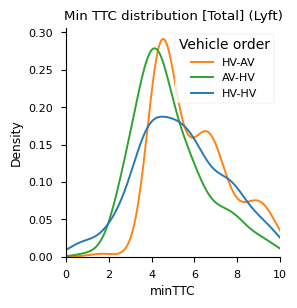

In [13]:
palette = {
    "HV-HV" : '#257ab6', 
    "AV-HV" : '#31a231',
    "HV-AV" : '#ff8214',
}

HVHV_COLOR = '#257ab6'
HVAV_COLOR = '#31a231'
AVHV_COLOR = '#ff8214'

FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df,
    x="minTTC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0,PET_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title("Min TTC distribution [Total] (Lyft)")
# plt.savefig("./outputs/plots/lyft_distribution_minTTC_Total.png", dpi=300, bbox_inches="tight")
plt.show()

### Merge

<Figure size 300x300 with 0 Axes>

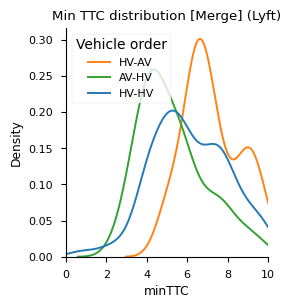

In [14]:
conflictType = "Merge"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]==conflictType],
    x="minTTC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

plt.xlim([0, minTTC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"Min TTC distribution [{conflictType}] (Lyft)")
plt.savefig(f"./outputs/plots/lyft_distribution_minTTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

### Cross

<Figure size 300x300 with 0 Axes>

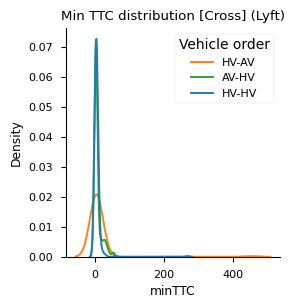

In [20]:
conflictType = "Cross"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df[conflict_df["Conflict type"]==conflictType],
    x="minTTC", 
    hue="Vehicle order",
    hue_order=["HV-HV", "AV-HV", "HV-AV"],
    kind="kde",
    common_norm=False,
    palette=palette,
    height=FIGURE_HEIGHT,
    aspect=1.0,
    legend=False,
)

# plt.xlim([0, minTTC_THRESHOLD])
# plt.ylim([0,0.15])
plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"Min TTC distribution [{conflictType}] (Lyft)")
plt.savefig(f"./outputs/plots/lyft_distribution_minTTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()